<a href="https://colab.research.google.com/github/Jaesu26/Dacon-3D-MNIST-image-classification/blob/main/%EC%88%AB%EC%9E%903D%EC%9D%B4%EB%AF%B8%EC%A7%80-%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 숫자 3D 이미지 분류 AI 경진대회

## 데이터 불러오기

In [383]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import h5py
import gc

from tqdm import tqdm, tqdm_notebook
from glob import glob

warnings.filterwarnings('ignore')

In [384]:
from google.colab import drive

drive.mount('/content/drive') ## 구글코랩과 구글드라이브 연결

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [385]:
%cd  '/content/drive/MyDrive/Colab Notebooks/숫자3D이미지-분류/Data'

/content/drive/MyDrive/Colab Notebooks/숫자3D이미지-분류/Data


In [386]:
# !unzip -qq '/content/drive/MyDrive/Colab Notebooks/숫자3D이미지-분류/Data/open.zip'

In [387]:
%cd  '/content/drive/MyDrive/Colab Notebooks/숫자3D이미지-분류'

/content/drive/MyDrive/Colab Notebooks/숫자3D이미지-분류


In [388]:
label_df = pd.read_csv('./Data/train.csv')
all_points = h5py.File('./Data/train.h5', 'r')

In [389]:
test_df = pd.read_csv('./Data/sample_submission.csv')
test_points = h5py.File('./Data/test.h5', 'r')

- 하이퍼파라미터

In [10]:
SAVE_PATH = './weight'
NUM_CLASSES = 4
N_FOLD = 5
MAX_LEN = 50
BATCH_SIZE = 64
EPOCHS = 10 
LEARNING_RATE = 2e-5
LABEL_SMOOTHING = 0.05
SEED = 2022

- 가중치 저장폴더

In [11]:
def create_folder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError as error:
        print(error)

In [12]:
# create_folder(SAVE_PATH)

## 시각화

- 라벨

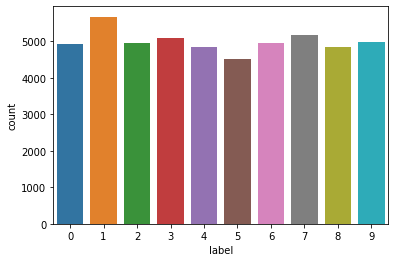

In [13]:
sns.countplot(data=label_df, x='label')

`-` 라벨별 개수는 비슷하다

In [359]:
def show_3Dimage(_3d_point_images, id: int, label_df=None):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    _3d_point_image = _3d_point_images[str(id)][:]
    x = _3d_point_image[:, 0]
    y = _3d_point_image[:, 1]
    z = _3d_point_image[:, 2]
    ax.scatter(x, y, z, alpha=0.04)

    if label_df is not None:
        label = label_df.loc[label_df['ID'] == id, 'label'].item()
        ax.set_title(label, fontsize=16)
    plt.show()

- 3차원 이미지

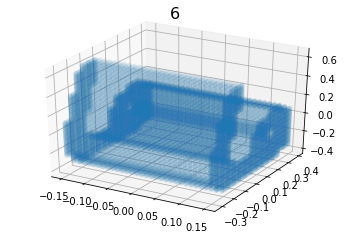

In [527]:
show_3Dimage(all_points, 49977, label_df)

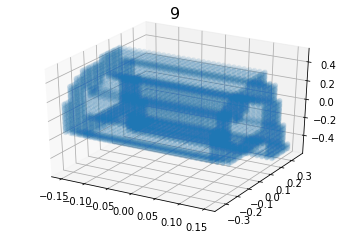

In [528]:
show_3Dimage(all_points, 49983, label_df)

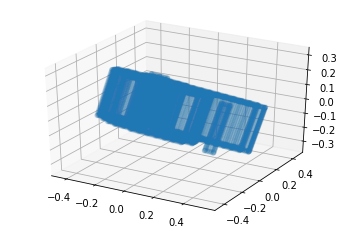

In [739]:
show_3Dimage(test_points, 81110)

`-` train 이미지는 yz 평면에 숫자를 그린 후 x축으로 팽창되어 있다

`-` test 이미지는 그렇지 않기에(1:1 비율) 적절한 변환이 필요하다  

`-` 6과 9는 뒤집어져 있으면 구분이 안되지만 위와 같이 옆으로 누워있는 3D 이미지도 존재한다

`-` 6의 경우 막대기가 강조되어 있으며 9의 경우 동그라미가 강조되어 있다 

`-` 2와 5도 뒤집어져 있으면 구분이 잘 안된다

`-` 나머지는 구분이 잘 된다

In [831]:
def svd_3d_to_2d(_3d_point_array):
    """
    SVD를 이용하여 3D 이미지를 2D 이미지로 축소
    사이킷런의 PCA 클래스는 data leakage 인지 헷갈려서 사용 안함
    """
    X = _3d_point_array
    U, d, V = np.linalg.svd(X.T @ X)
    V_tilde = np.column_stack((V[:, 1], -V[:, 0])) ## 각도 조절
    _2d_point_array = X @ V_tilde
    return _2d_point_array

In [903]:
def eig_3d_to_2d(_3d_point_array):
    """
    고유값 분해를 이용하여 3D 이미지를 2D 이미지로 축소
    사이킷런의 PCA 클래스는 data leakage 인지 헷갈려서 사용 안함
    """
    X = _3d_point_array
    Lambda, Psi = np.linalg.eig(X.T @ X)
    _1st, _2nd, _3rd = sorted(Lambda, key = lambda x: -x)
    idx_1st = np.array(list(np.where(Lambda == _1st))).item(0, 0)
    idx_2nd = np.array(list(np.where(Lambda == _2nd))).item(0, 0)
    
    Psi_tilde = np.column_stack((-Psi[:, idx_1st], Psi[:, idx_2nd]))
    _2d_point_array = X @ Psi_tilde
    return _2d_point_array

`-` SVD와 고유값 분해는 차이가 존재한다

`-` PCA는 고유값 분해와 output이 동일하다 (각도만 다르다)



In [914]:
def show_2Dimages(_3d_point_images, id):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 6))
    pca = PCA(n_components=2)

    svd_z = svd_3d_to_2d(_3d_point_images[str(id)][:])
    eig_z = eig_3d_to_2d(_3d_point_images[str(id)][:])
    pca_z = pca.fit_transform(_3d_point_images[str(id)][:])

    ax1.plot(svd_z[:,0], svd_z[:,1], '.', alpha=0.5)
    ax2.plot(eig_z[:,0], eig_z[:,1], '.', alpha=0.5)
    ax3.plot(pca_z[:,0], pca_z[:,1], '.', alpha=0.5)

    ax1.set_title('SVD')
    ax2.set_title('Eigen')
    ax3.set_title('PCA')
    plt.show()    

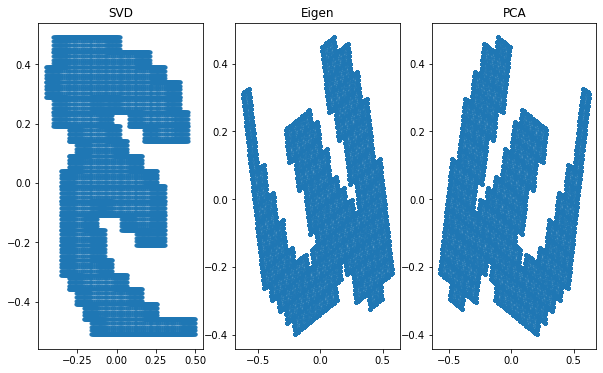

In [918]:
show_2Dimages(all_points, 983)

- 3차원 이미지 좌표의 분포 확인

- train

In [442]:
count = 0
for i in tqdm(range(50000, 90000)):
    data = test_points[str(i)][:]
    xx = np.max(data[:, 0])
    if xx >= 0.16:
        count += 1

100%|██████████| 40000/40000 [04:07<00:00, 161.62it/s]


In [443]:
count

19987

In [67]:
x_data, y_data, z_data = [], [], []
for i in tqdm(range(50000)):
    data = all_points[str(i)][:]
    x_data.extend(list(set(data[:, 0])))
    y_data.extend(list(set(data[:, 1])))
    z_data.extend(list(set(data[:, 2])))

100%|██████████| 50000/50000 [09:55<00:00, 84.03it/s]


In [82]:
len(x_data), len(y_data), len(z_data)

(19421718, 3182493, 8463666)

{'boxes': [<matplotlib.lines.Line2D at 0x7f52f4822710>],
 'caps': [<matplotlib.lines.Line2D at 0x7f52f482d750>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f52f4836750>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f52f4836250>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f52f4822c90>,
  <matplotlib.lines.Line2D at 0x7f52f482d210>]}

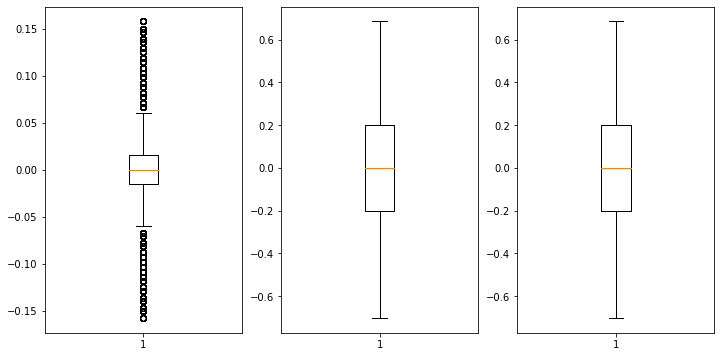

In [86]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
ax1.boxplot(x_data)
ax2.boxplot(y_data)
ax3.boxplot(y_data)

- test

In [64]:
x_data, y_data, z_data = [], [], []
dot_counts = []
for i in tqdm(range(50000, 55000)):
    data = test_points[str(i)][:]
    dot_counts.append(data.shape[0])
    x_data.extend(list(set(data[:, 0])))
    y_data.extend(list(set(data[:, 1])))
    z_data.extend(list(set(data[:, 2])))

100%|██████████| 5000/5000 [01:30<00:00, 55.02it/s]


In [67]:
len(x_data), len(y_data), len(z_data), max(dot_counts)

(42576466, 41770274, 42032192, 34750)

{'boxes': [<matplotlib.lines.Line2D at 0x7efc8f53ef50>],
 'caps': [<matplotlib.lines.Line2D at 0x7efc8f548d50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7efc8f54fe50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7efc8f54f910>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7efc8f548390>,
  <matplotlib.lines.Line2D at 0x7efc8f5488d0>]}

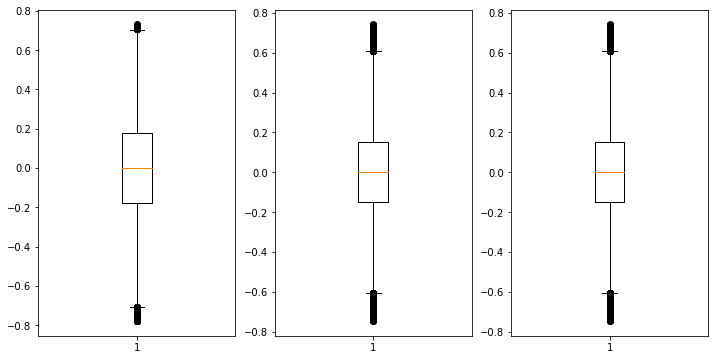

In [68]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
ax1.boxplot(x_data)
ax2.boxplot(y_data)
ax3.boxplot(y_data)

`-` train과 비교했을 때 x축의 범위가 5배는 더 넓다

`-` train 데이터의 경우 x축의 범위가 -0.15~0.15 이다

`-` train 이미지는 yz 평면에 숫자를 그리고 x축으로 팽창시킨 반면에 test는 그렇지 않다

`-` RAM 용량 문제로 test data는 5000개만 사용함

## 데이터 전처리

`-` 위의 시각화를 보면 3차원이 아니라 2차원이더라도 숫자를 구분할 수 있을 듯하다

`-` 3차원 이미지를 2차원 이미지로 변경하자

`-` pretrained model도 사용할 수 있으며 파라미터도 더 적어진다

### 3D 이미지 $\to$ 2D 이미지 

`-` 3D 이미지는 축 하나의 범위가 -0.15 ~ 0.15인 경우와 그렇지 않은 경우로 나뉜다

`-` 전자의 경우 -0.15 ~ 0.15의 범위를 가지는 축으로 3차원 점들을 정사영시키면 된다 

`-` 후자의 경우 특이값 분해와 고유값 분해를 이용하여 2차원 이미지로 만든다

In [919]:
def z_scale(_3d_points):
    x = _3d_points[:, 0]
    y = _3d_points[:, 1]
    z = _3d_points[:, 2]

    xx = (x - np.mean(x)) / np.std(x)
    yy = (y - np.mean(y)) / np.std(y)
    zz = (z - np.mean(z)) / np.std(z)

    _3d_scaled_points = np.column_stack((xx, yy, zz))
    return _3d_scaled_points

## 데이터 셋 및 딥러닝 모델 정의

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader